## Skorch SA network classification example

In [6]:
import numpy as np
from sklearn.datasets import make_classification
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from pyperch.neural.sa_nn import SAModule  
from pyperch.utils.decorators import add_to
from skorch.dataset import unpack_data
import copy
import matplotlib.pyplot as plt

In [7]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=SAModule,
    module__input_dim=7,
    module__output_dim=2,
    module__hidden_units=10,
    module__hidden_layers=1,
    module__step_size=.05,
    module__t=1000,
    module__cooling=.9,
    max_epochs=1000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

## train_step_single override - add SA training step and disable backprop 

In [8]:
from src.alien import alien

obj=alien()
X_train, y_train=obj.dataset(modify_feature=True)
X = X_train.astype(np.float32)
y = y_train.astype(np.int64)

In [9]:
SAModule.register_sa_training_step()

In [10]:
import time
start=time.time()
net.fit(X, y)
print(time.time()-start)
print(net.history[:, 'valid_acc'][-1])

/home/duan/.conda/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


43.0616021156311
0.8202824133504493


## Plot learning curves

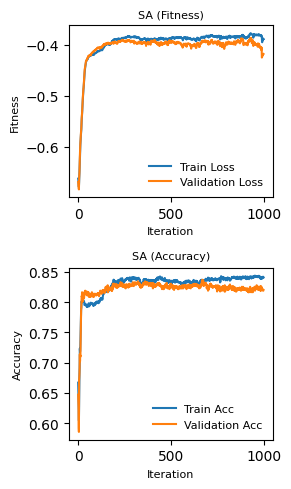

In [14]:
# plot the iterative learning curve (loss)
fig = plt.figure(figsize=(3,5))
ax1=fig.add_subplot(2,1,1)



plt.plot(-np.array(net.history[:, 'train_loss']), label='Train Loss')
plt.plot(-np.array(net.history[:, 'valid_loss']), label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fitness")
ax1.set_title("SA (Fitness)")
# plt.grid(visible=True)
plt.legend(frameon=False)

ax2=fig.add_subplot(2,1,2)
plt.plot(net.history[:, 'train_acc'], label='Train Acc')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("SA (Accuracy)")
# plt.grid(visible=True)
plt.legend(frameon=False)


plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/fitness_SA_NN.pdf')
plt.show()

## Using sklearn learning curve with RO

In [15]:
from sklearn.model_selection import learning_curve

# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)

fig = plt.figure(figsize=(3,2.5))

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     )
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
plt.plot(train_sizes, train_scores_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Test score", marker='o')
plt.title("SA")
plt.xlabel("Training size")
plt.ylabel("Score")
# plt.grid(visible=True)
plt.legend(frameon=False)

plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/accuracy_SA_NN.pdf')
plt.show()

NameError: name 'train_scores' is not defined

<Figure size 300x250 with 0 Axes>

## Using sklearn grid search with RO

In [ ]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0, )

# module specific parameters need to begin with 'module__'
default_params = {
    'module__input_dim': [7],
    'module__output_dim': [2],
    'max_epochs': [1000],
    'module__step_size': [0.01,0.05, 0.1],
    'module__t': [1000,20000],
}

grid_search_params = {
    'module__cooling': [0.9, 0.95, 0.99],
    **default_params,
}

gs = GridSearchCV(net, grid_search_params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=1000; total time=  30.4s
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=1000; total time=  29.6s
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=1000; total time=  29.9s
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=20000; total time=  30.0s
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=20000; total time=  29.6s
[CV] END max_epochs=1000, module__cooling=0.9, module__input_dim=7, module__output_dim=2, module__step_size=0.01, module__t=20000; total time=  30.1s
[CV] END max_epochs=1000, module__cooling=